In [1]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

# 0) Dataset for Modeling: Final Preparations

## 0.1) Importing data from Drive & defining variable sets
* automated version need to have a daily updated file/database entries

In [2]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet(r"C:\Users\paulina.pyzel\sa\content\stocks_df_combined_2025_06_13.parquet.brotli")


In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [4]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [5]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [6]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [7]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [8]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [9]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [10]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\2841410488.py:2: RuntimeWarning: divide by zero encountered in log
  df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))


In [11]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [12]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [13]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')


Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [14]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [15]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [16]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['Close_x',
 'Dividends',
 'Stock Splits',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'Close_y']

In [17]:
df_full.Ticker.nunique()

33

In [18]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

min        max  count
Ticker                                    
AAPL          1980-12-12 2025-06-13  11217
ACN           2001-07-19 2025-06-13   6012
AMZN          1997-05-15 2025-06-13   7065
ASML          1995-03-15 2025-06-13   7614
AVGO          2009-08-06 2025-06-13   3989
BHARTIARTL.NS 2002-07-01 2025-06-13   5698
BRK-B         1996-05-09 2025-06-13   7322
CDI.PA        1992-01-27 2025-06-13   8610
GOOG          2004-08-19 2025-06-13   5239
HDB           2001-07-20 2025-06-13   6011
HINDUNILVR.NS 1996-01-01 2025-06-13   7396
IBN           2000-03-28 2025-06-13   6342
IDEXY         2010-01-20 2025-06-13   3875
INFY          1999-03-11 2025-06-13   6607
ITC.NS        1996-01-01 2025-06-13   7393
JPM           1980-03-17 2025-06-13  11405
LICI.NS       2022-05-17 2025-06-13    761
LLY           1972-06-01 2025-06-13  13371
LT.NS         2002-07-01 2025-06-13   5701
MC.PA         2000-01-03 2025-06-13   6540
META          2012-05-18 2025-06-13   3287
MSFT          1986-03-13 2025-06-13   9891
NVDA          1999-01-22 2025-06-13   6640
NVO           1981-04-30 2025-06-13  11122
OR.PA         2000-01-03 2025-06-13   6540
RELIANCE.NS   1996-01-01 2025-06-13   7393
RMS.PA        2000-01-03 2025-06-13   6540
SAP           1995-09-18 2025-06-13   7485
SBIN.NS       1996-01-01 2025-06-13   7394
SIE.DE        1996-11-08 2025-06-13   7326
TCS.NS        2002-08-12 2025-06-13   5669
TTE           1991-10-25 2025-06-13   8469
V             2008-03-19 2025-06-13   4338

In [19]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 204 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(130), int32(64), int64(5), object(2)
memory usage: 253.1+ MB


In [20]:
# let look at the features count and df size:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 225.3 MB


## 0.2) [Code snippet 1] Generating dummies

In [21]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [22]:
# dummy variables are not generated from Date and numeric variables
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\43129475.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'Month'] = df.Month.dt.strftime('%B')
C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\43129475.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' ... '2' '3' '4']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:,'Weekday'] = df.Weekday.astype(str)


In [23]:
df.loc[:, 'Week-of-Month'] = df['Date'].dt.day.apply(lambda d: (d - 1) // 7 + 1)
df['month_wom'] = df['Month'] + '_w' + df['Week-of-Month'].astype(str)

C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\2654838739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Week-of-Month'] = df['Date'].dt.day.apply(lambda d: (d - 1) // 7 + 1)
C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\2654838739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_wom'] = df['Month'] + '_w' + df['Week-of-Month'].astype(str)


In [24]:
print(df['month_wom'])

3490    January_w1
3491    January_w1
3492    January_w1
3493    January_w1
3494    January_w1
           ...    
5696       June_w2
5697       June_w2
5698       June_w2
5699       June_w2
5700       June_w2
Name: month_wom, Length: 191795, dtype: object


In [25]:
CATEGORICAL.append('month_wom')

In [26]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [27]:
# TODO 1: define more categorical features, e.g. all combinations for <September+weekday>  (you'll see that September is actually an important dummy in one of the models)

In [28]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 85.6 MB


In [29]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()

In [30]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [31]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 299 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 309.5 MB


## 0.3) [Code Snippet 2] Correlation analysis
* first approximation of "important" variables correlated with all variables we want to predict (TO_PREDICT)

In [32]:
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [33]:
corr_is_positive_growth_30d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_30d_future']

In [34]:
# create a dataframe for an easy way to sort
corr_is_positive_growth_30d_future_df = pd.DataFrame(corr_is_positive_growth_30d_future)


In [35]:
filtered_df = corr_is_positive_growth_30d_future_df [corr_is_positive_growth_30d_future_df.index.astype(str).str.startswith("month_wom")]
filtered_df['abs']=abs(corr_is_positive_growth_30d_future_df.is_positive_growth_30d_future)
filtered_df.sort_values(by='abs',ascending=False).head(5)

C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\3642459294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['abs']=abs(corr_is_positive_growth_30d_future_df.is_positive_growth_30d_future)


is_positive_growth_30d_future       abs
month_wom_October_w4                        0.024968  0.024968
month_wom_November_w3                       0.022097  0.022097
month_wom_November_w2                       0.018822  0.018822
month_wom_January_w2                       -0.018327  0.018327
month_wom_October_w3                        0.017734  0.017734

In [36]:
corr_is_positive_growth_30d_future_df.sort_values(by='is_positive_growth_30d_future').head(5)

is_positive_growth_30d_future
DGS10                                      -0.067204
DGS5                                       -0.059812
gdppot_us_yoy                              -0.058374
gdppot_us_qoq                              -0.058125
growth_brent_oil_365d                      -0.056158

In [37]:
corr_is_positive_growth_30d_future_df.sort_values(by='is_positive_growth_30d_future').tail(8)

is_positive_growth_30d_future
growth_btc_usd_7d                                   0.028577
Month_November                                      0.033807
Month_October                                       0.035410
growth_future_30d                                   0.696468
is_positive_growth_30d_future                       1.000000
cdl3starsinsouth                                         NaN
cdlconcealbabyswall                                      NaN
cdlmathold                                               NaN

In [38]:
corr_growth_future_30d = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['growth_future_30d']

In [39]:
corr_growth_future_30d_df = pd.DataFrame(corr_growth_future_30d)

In [40]:
corr_growth_future_30d_df.sort_values(by='growth_future_30d').head(5)

growth_future_30d
growth_brent_oil_365d          -0.084665
growth_dji_365d                -0.075940
growth_dax_365d                -0.060016
growth_wti_oil_365d            -0.055917
growth_snp500_365d             -0.055443

In [41]:
corr_growth_future_30d_df.sort_values(by='growth_future_30d').tail(8)

growth_future_30d
ln_volume                               0.052015
Ticker_NVDA                             0.052434
Month_October                           0.054752
is_positive_growth_30d_future           0.696468
growth_future_30d                       1.000000
cdl3starsinsouth                             NaN
cdlconcealbabyswall                          NaN
cdlmathold                                   NaN

## 0.4) [Code snippet 3] Temporal split of ~25 years of data (by date)

In [42]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [43]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [44]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [45]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling: "rule of thumb" or hand-predictions

In [46]:
# let's have a time-series or one ticker
df_nvda = new_df[new_df.Ticker=='NVDA']

In [47]:
fig = px.line(df_nvda, x="Date", y="Close_x", title='NVDA price')
fig.show()

In [48]:
# TRAIN / VALIDATION/ TEST split

# Calculate the lengths of each split -- this is not temporal split, but based on the number of observations --> "classic" split with no shuffle
total_length = len(df_nvda)
train_length = int(0.8 * total_length)
val_length = int(0.1 * total_length)

# Split the data
train_data = df_nvda.iloc[:train_length]
val_data = df_nvda.iloc[train_length:train_length+val_length]
test_data = df_nvda.iloc[train_length+val_length:]

# Plot the data
fig = px.line(title='NVDA Close price daily for three time intervals Train/Validation/Test')
fig.add_scatter(x=train_data['Date'], y=train_data['Close_x'], mode='lines', name='Train', line=dict(color='blue'))
fig.add_scatter(x=val_data['Date'], y=val_data['Close_x'], mode='lines', name='Validation', line=dict(color='orange'))
fig.add_scatter(x=test_data['Date'], y=test_data['Close_x'], mode='lines', name='Test', line=dict(color='green'))

# Update layout to center the title
fig.update_layout(title=dict(x=0.5))

fig.show()

In [49]:
# HIST ON NVDA DATA Train/Test/Validation
import plotly.graph_objects as go

# Plot the data
fig = go.Figure()

# Add histograms for each split
fig.add_trace(go.Histogram(x=train_data['growth_future_30d'], name='Train', opacity=0.75))
fig.add_trace(go.Histogram(x=val_data['growth_future_30d'], name='Validation', opacity=0.75))
fig.add_trace(go.Histogram(x=test_data['growth_future_30d'], name='Test', opacity=0.75))

fig.update_layout(barmode='overlay', title='Distribution of growth_future_30d for NVIDIA (NVDA) Growth by Train/Valid/Test sets')
fig.update_traces(opacity=0.75)

fig.show()


In [50]:
# HIST ON ALL DATA Train/Test/Validation
# comment: there are some outliers and hard co compare the distributions
import plotly.graph_objects as go

# Plot the data
fig = go.Figure()

# Add histograms for each split
fig.add_trace(go.Histogram(x=df_with_dummies[df_with_dummies.split=='train']['growth_future_30d'], name='Train', opacity=0.75))
fig.add_trace(go.Histogram(x=df_with_dummies[df_with_dummies.split=='validation']['growth_future_30d'], name='Validation', opacity=0.75))
fig.add_trace(go.Histogram(x=df_with_dummies[df_with_dummies.split=='test']['growth_future_30d'], name='Test', opacity=0.75))

fig.update_layout(barmode='overlay', title='Distribution of growth_future_30d for All tickers Growth by Train/Valid/Test sets')
fig.update_traces(opacity=0.75)

fig.show()

In [51]:
# Assuming df_with_dummies is your DataFrame containing the 'growth_future_5d' variable and 'split' column

# Create the histogram
fig = px.histogram(new_df,
                   x="growth_future_30d",
                   color="split",
                   marginal="box", # or violin, rug
                   )
                  #  hover_data=new_df.growth_future_5d)

# Show the histogram
fig.show()

In [52]:
new_df.groupby(by='split')['growth_future_30d'].describe()

count      mean       std       min       25%       50%  \
split                                                                    
test         30418.0  1.019899  0.102172  0.580332  0.955986  1.016057   
train       129730.0  1.023864  0.123190  0.246131  0.960248  1.020585   
validation   30657.0  1.029596  0.099908  0.461847  0.973991  1.030784   

                 75%       max  
split                           
test        1.077950  1.648934  
train       1.083310  5.179689  
validation  1.086687  1.783610

In [53]:
# is_positive_growth_5d_future: ONLY NVDA stock

# Count occurrences of 0 and 1 for each split
train_counts = train_data['is_positive_growth_30d_future'].value_counts(normalize=True)*100
val_counts = val_data['is_positive_growth_30d_future'].value_counts(normalize=True)*100
test_counts = test_data['is_positive_growth_30d_future'].value_counts(normalize=True)*100

# Plot the data
fig = go.Figure()

# # Add stacked bar charts for each split
# fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[0], val_counts[0], test_counts[0]], name='0'))
# fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[1], val_counts[1], test_counts[1]], name='1'))


# Add stacked bar charts for each split
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[0], val_counts[0], test_counts[0]], name='0',
                     text=[f'{count:.2f}%' for count in [train_counts[0], val_counts[0], test_counts[0]]], textposition='auto'))
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[1], val_counts[1], test_counts[1]], name='1',
                     text=[f'{count:.2f}%' for count in [train_counts[1], val_counts[1], test_counts[1]]], textposition='auto'))


fig.update_layout(barmode='stack', title='Distribution of is_positive_growth_30d_future by Train/Validation/Test for NVDA stock')
fig.update_traces(opacity=0.75)

fig.show()

In [54]:
# ALL STOCKS: train/test/validation is more similar

# Count occurrences of 0 and 1 for each split
train_counts = df_with_dummies[df_with_dummies.split=='train']['is_positive_growth_30d_future'].value_counts(normalize=True)*100
val_counts = df_with_dummies[df_with_dummies.split=='validation']['is_positive_growth_30d_future'].value_counts(normalize=True)*100
test_counts = df_with_dummies[df_with_dummies.split=='test']['is_positive_growth_30d_future'].value_counts(normalize=True)*100

# Plot the data
fig = go.Figure()


# Add stacked bar charts for each split
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[0], val_counts[0], test_counts[0]], name='0',
                     text=[f'{count:.2f}%' for count in [train_counts[0], val_counts[0], test_counts[0]]], textposition='auto'))
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[1], val_counts[1], test_counts[1]], name='1',
                     text=[f'{count:.2f}%' for count in [train_counts[1], val_counts[1], test_counts[1]]], textposition='auto'))


fig.update_layout(barmode='stack', title='Distribution of is_positive_growth_30d_future by Train/Validation/Test for ALL stocks')
fig.update_traces(opacity=0.75)

fig.show()

# 1) Modeling: "rule of thumb" or hand-predictions

## 1.1) Review all the inputs again

In [55]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [56]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 322 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(178), int64(6), object(6)
memory usage: 342.4+ MB


In [57]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

Open       High      Low    Close_x      Volume  Dividends  \
3490  35.975752  36.358881  34.3283  35.726719  53228400.0        0.0   

      Stock Splits Ticker  Year    Month  ... month_wom_October_w2  \
3490           0.0   MSFT  2000  January  ...                    0   

     month_wom_October_w3  month_wom_October_w4  month_wom_October_w5  \
3490                    0                     0                     0   

      month_wom_September_w1  month_wom_September_w2  month_wom_September_w3  \
3490                       0                       0                       0   

      month_wom_September_w4  month_wom_September_w5  split  
3490                       0                       0  train  

[1 rows x 322 columns]

In [58]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

max        min   count
split                                   
test       2025-06-13 2021-08-20   31408
train      2017-10-25 2000-01-03  129730
validation 2021-08-19 2017-10-26   30657

In [59]:
# what we try to predict
new_df[TO_PREDICT].head(1)

growth_future_30d  is_positive_growth_30d_future
3490           0.845576                              0

In [60]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

growth_1d  growth_3d  growth_7d  growth_30d  growth_90d  growth_365d  \
3490   0.998394   0.988341   0.991494    1.372333     1.22295     2.063054   

      growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  ...  \
3490       0.970196       0.983855       1.051736        1.134572  ...   

      month_wom_October_w1  month_wom_October_w2  month_wom_October_w3  \
3490                     0                     0                     0   

      month_wom_October_w4  month_wom_October_w5  month_wom_September_w1  \
3490                     0                     0                       0   

      month_wom_September_w2  month_wom_September_w3  month_wom_September_w4  \
3490                       0                       0                       0   

      month_wom_September_w5  
3490                       0  

[1 rows x 299 columns]

## 1.2) [Code Snippet 3] Manual "hand rule" predictions
* CCI (binary, on technical indicator CCI)
* growth_1d>1
* growth_1d>1 & growth_snp500_1d>1
*

In [61]:
# why does it work?
# compare a vector (pandas.core.series.Series) with scalar 200 ==> element_wise comparison with the number ==> generate a new DataFrame
# (only 5 values)
pd.DataFrame(new_df.cci>200).head()

cci
3490  False
3491  False
3492  False
3493  False
3494  False

In [62]:
new_df.DGS10

3490    6.58
3491    6.49
3492    6.62
3493    6.57
3494    6.52
        ... 
5696    4.49
5697    4.47
5698    4.41
5699    4.36
5700    4.36
Name: DGS10, Length: 191795, dtype: float64

In [63]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)
new_df['pred3_manual_dgs10_5'] = (new_df.DGS10 <= 4) & (new_df.DGS5 <= 1)
new_df['pred4_manual_dgs10_fedfunds'] = (new_df.DGS10 > 4) & (new_df.FEDFUNDS <= 4.795)

In [64]:
# TODO 2: find more "hand rules" - can get it from decision trees important factors, or randomly build on other most popular macro/tech indicators/ manual_features

In [65]:
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','is_positive_growth_30d_future']].sample(10)

cci  growth_30d  growth_snp500_30d  pred0_manual_cci  \
3011   40.632149    1.083620           1.098284                 0   
2251  -77.011630    0.867787           1.008013                 0   
266    79.935463    1.043305           1.078781                 0   
7285  139.298208    1.331819           1.069490                 0   
4691  116.097591    1.036659           1.008892                 0   
3308 -137.810096    1.015720           1.030939                 0   
5050  -62.423489    0.952911           0.984201                 0   
5956   56.967938    1.118832           0.987679                 0   
7615  106.801101    1.032258           1.016586                 0   
9021   86.024196    1.047984           0.981141                 0   

      pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  \
3011                     1                             1   
2251                     0                             0   
266                      1                             1   
7285                     1                             1   
4691                     1                             1   
3308                     1                             1   
5050                     0                             0   
5956                     1                             0   
7615                     1                             1   
9021                     1                             0   

      is_positive_growth_30d_future  
3011                              1  
2251                              1  
266                               1  
7285                              1  
4691                              1  
3308                              1  
5050                              1  
5956                              1  
7615                              0  
9021                              0

In [66]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [67]:
p = PREDICTIONS[0]
part1 = p.split('_')[0] # first prefix before '_'
print(f'Full column name: {p}, only first part: {part1}')

Full column name: pred0_manual_cci, only first part: pred0


In [68]:
# One prediction: do we predict correctly?
new_df['is_correct_prediction'] = (new_df.pred0_manual_cci == new_df.is_positive_growth_30d_future)

In [69]:
new_df[['cci','pred0_manual_cci','is_positive_growth_30d_future','is_correct_prediction']]
new_df.head(5)

Open       High        Low    Close_x      Volume  Dividends  \
3490  35.975752  36.358881  34.328300  35.726719  53228400.0        0.0   
3491  34.807221  35.899137  34.404936  34.519875  54119000.0        0.0   
3492  34.060124  35.669264  33.523744  34.883850  64059600.0        0.0   
3493  34.385780  34.903004  33.217238  33.715305  54976600.0        0.0   
3494  33.293845  34.404917  32.891561  34.155884  62013600.0        0.0   

      Stock Splits Ticker  Year    Month  ... month_wom_September_w3  \
3490           0.0   MSFT  2000  January  ...                      0   
3491           0.0   MSFT  2000  January  ...                      0   
3492           0.0   MSFT  2000  January  ...                      0   
3493           0.0   MSFT  2000  January  ...                      0   
3494           0.0   MSFT  2000  January  ...                      0   

     month_wom_September_w4  month_wom_September_w5  split  pred0_manual_cci  \
3490                      0                       0  train                 0   
3491                      0                       0  train                 0   
3492                      0                       0  train                 0   
3493                      0                       0  train                 0   
3494                      0                       0  train                 0   

      pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  \
3490                     1                             1   
3491                     1                             0   
3492                     1                             0   
3493                     1                             0   
3494                     1                             1   

      pred3_manual_dgs10_5  pred4_manual_dgs10_fedfunds  is_correct_prediction  
3490                 False                        False                   True  
3491                 False                        False                   True  
3492                 False                        False                   True  
3493                 False                        False                   True  
3494                 False                        False                   True  

[5 rows x 328 columns]

In [70]:
# check "Precision" : the percentage of "correct" predictions , WHEN we predict "1" (POSITIVE future growth)
filter = (new_df.split=='test') & (new_df.pred0_manual_cci==1)
new_df[filter].is_correct_prediction.value_counts()


is_correct_prediction
True     443
False    351
Name: count, dtype: int64

In [71]:
# %% of correct predictions : 54%
new_df[filter].is_correct_prediction.value_counts() / len(new_df[filter])

is_correct_prediction
True     0.557935
False    0.442065
Name: count, dtype: float64

In [72]:
# delete this column
del new_df["is_correct_prediction"]

In [73]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_30d_future).astype(int)

In [74]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [75]:
# sample of a dataframe
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(5)

pred0_manual_cci  pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  \
7815                 0                     0                             0   
2124                 0                     1                             1   
4886                 0                     1                             1   
3860                 0                     1                             1   
4646                 0                     1                             1   

      pred3_manual_dgs10_5  pred4_manual_dgs10_fedfunds  is_correct_pred0  \
7815                  True                        False                 0   
2124                 False                        False                 1   
4886                  True                        False                 1   
3860                  True                        False                 1   
4646                 False                        False                 0   

      is_correct_pred1  is_correct_pred2  is_correct_pred3  is_correct_pred4  \
7815                 0                 0                 1                 0   
2124                 0                 0                 1                 1   
4886                 0                 0                 0                 1   
3860                 0                 0                 0                 1   
4646                 1                 1                 0                 0   

      is_positive_growth_30d_future  
7815                              1  
2124                              0  
4886                              0  
3860                              0  
4646                              1

In [76]:
len(new_df[new_df.split=='test'])

31408

In [77]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter = (new_df.split=='test') & (new_df[prediction_column]==1)
  print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
  print(new_df[filter][is_correct_column].value_counts())
  print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))

  print('---------')

Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
---------
Prediction column:pred3_manual_dgs10_5 , is_correct_column: is_correct_pred3
is_correct_pred3
1    578
0    419
Name: count, dtype: int64
is_correct_pred3
1    0.579739
0    0.420261
Name: count, dtype: float64
---------
Prediction column:pred4_manual_dgs10_fedfunds , is_correct_column: is_correct_pred4
is_correct_pred4
0    30

## 1.3) [Code Snippet 4 - Advanced] Statistical prediction : ARIMA models with 3 parameters (p,q,r)
* Finding best ARIMA params: not used in 2025

In [78]:

import pandas as pd

# Set 'Date' as the index
df_arima = df_nvda.copy()

df_arima.set_index('Date', inplace=True)
df_arima.head()

# use ONLY time-series values and no other features
train_validation = df_arima[df_arima.split.isin(['train','validation'])]['Close_x']
test = df_arima[df_arima.split.isin(['test'])]['Close_x']

# this is needed to make a decision about investing for 5 days
test_is_positive_future_30d = df_arima[df_arima.split.isin(['test'])]['is_positive_growth_30d_future']


In [79]:
# !pip install pmdarima
# from pmdarima import auto_arima

In [80]:
# Hyper parameters optimization
# # ~ several minutes to run
# # https://miqbalrp.medium.com/exploring-autoarima-in-python-for-multiple-time-series-forecasting-2f3004ba5a49
# # https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
# # Auto ARIMA model fitting: iterating across params
# best_arima_model = auto_arima(train_validation,
#                    seasonal=False,
#                    trace=True,
#                    start_p=0, start_q=0, # minimum p and q
#                    max_p=12, max_q=12,   # maximum p and q
#                    D=None,               # let model determine 'D'
#                    )

In [81]:
# best model specification trained on train_validation
# # (p=6, q=2, r=2)
# best_arima_model.get_params()['order']

# model parameters ("coef" for auto-regression (AR) and moving-average (MA))
# best_arima_model.summary()

In [82]:
# need to do 918 predictions for 1 stock
len(test)

958

In [83]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [84]:
# [last day] this was used to train the model and obtain the "best" params
train_validation[-1:]

Date
2021-08-19    19.756039
Name: Close_x, dtype: float64

In [85]:
# # history as Series and the "last value" (current last known data)
history = [x for x in train_validation]
history[-1]

19.756038665771484

In [86]:
# [last day] now need to predict for each value of test, using all available history
test[-1:]

Date
2025-06-13    141.970001
Name: Close_x, dtype: float64

In [87]:
# slow to predict, can't quickly predict for ALL 33 tickers * 918 observationa (~30k predictions). Let's have only 1 ticker and these periods to predict:
# change this to 10 (1 min) or 50 (5min) to run faster

PERIODS_TO_PREDICT = 10  # ~2 minute to predict
# PERIODS_TO_PREDICT = 500  #VERY SLOW: used for slides

In [88]:
# staring to predict at day1 of test dataframe (we SEE the adj_close price and predict 5 periods ahead)
df_arima[df_arima.split=='test'].head(5)

Open       High        Low    Close_x       Volume  \
Date                                                                  
2021-08-20  19.948622  20.820769  19.890746  20.771873  675741000.0   
2021-08-23  20.926550  21.950374  20.905594  21.911457  575807000.0   
2021-08-24  21.706889  21.912452  21.489351  21.746803  297299000.0   
2021-08-25  21.690926  22.422372  21.675958  22.165916  347701000.0   
2021-08-26  22.152945  22.292648  21.743814  22.021225  237940000.0   

            Dividends  Stock Splits Ticker  Year   Month  ...  \
Date                                                      ...   
2021-08-20        0.0           0.0   NVDA  2021  August  ...   
2021-08-23        0.0           0.0   NVDA  2021  August  ...   
2021-08-24        0.0           0.0   NVDA  2021  August  ...   
2021-08-25        0.0           0.0   NVDA  2021  August  ...   
2021-08-26        0.0           0.0   NVDA  2021  August  ...   

           month_wom_October_w2  month_wom_October_w3  month_wom_October_w4  \
Date                                                                          
2021-08-20                    0                     0                     0   
2021-08-23                    0                     0                     0   
2021-08-24                    0                     0                     0   
2021-08-25                    0                     0                     0   
2021-08-26                    0                     0                     0   

            month_wom_October_w5  month_wom_September_w1  \
Date                                                       
2021-08-20                     0                       0   
2021-08-23                     0                       0   
2021-08-24                     0                       0   
2021-08-25                     0                       0   
2021-08-26                     0                       0   

            month_wom_September_w2  month_wom_September_w3  \
Date                                                         
2021-08-20                       0                       0   
2021-08-23                       0                       0   
2021-08-24                       0                       0   
2021-08-25                       0                       0   
2021-08-26                       0                       0   

            month_wom_September_w4  month_wom_September_w5  split  
Date                                                               
2021-08-20                       0                       0   test  
2021-08-23                       0                       0   test  
2021-08-24                       0                       0   test  
2021-08-25                       0                       0   test  
2021-08-26                       0                       0   test  

[5 rows x 321 columns]

In [89]:
# 2025: static params, instead of autotuned

# p,q,r = best_arima_model.get_params()['order']
p,q,r = 6,2,2

In [90]:
# rolling forecast for ARIMA(6,2,2) model
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/



# start from all previous history of train_validation
history = [x for x in train_validation]
predictions = []
decisions = []
is_correct_decisions = []

tp=0 # true positive
fp=0 # false positive

# walk-forward validation for PERIODS_TO_PREDICT
for t in range(PERIODS_TO_PREDICT):
  current_adj_close = test[t] # current adj_close price when we do the prediction
  current_is_future_growth_30d = test_is_positive_future_30d[t]

  model = ARIMA(history, order = (p,q,r)) # substitute best parameters AND RETRAIN the model (very expensive)
  model_fit = model.fit()
  output = model_fit.forecast(steps=30) # forecast for 5 periods ahead

  yhat = output[29] # prediction 30 periods ahead

  if output[29] > current_adj_close:
    prediction = 1
  else:
    prediction = 0

  is_correct = (prediction==current_is_future_growth_30d).astype(int)

  if prediction == 1:
    if is_correct ==1:
      tp+=1
    else:
      fp+=1

  predictions.append(yhat)

  decisions.append(prediction)
  is_correct_decisions.append(is_correct)
  obs = test[t+6]
  history.append(obs) # add last element to history
  print(f'step {t}, current_price = {np.round(current_adj_close,1)}, [30 periods] predicted={np.round(output,1)}, expected={np.round(test[t+1:t+29].values,1)}, decision = {prediction}, is_correct = {is_correct} ')



C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\1477264127.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\1477264127.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\paulina.pyzel\AppData\Local\Temp\ipykernel_17308\1477264127.py:43: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

step 0, current_price = 20.8, [30 periods] predicted=[19.7 19.8 19.9 19.9 19.9 19.9 20.  20.  20.  20.1 20.1 20.1 20.2 20.2
 20.3 20.3 20.3 20.4 20.4 20.4 20.5 20.5 20.5 20.6 20.6 20.6 20.7 20.7
 20.7 20.8], expected=[21.9 21.7 22.2 22.  22.6 22.6 22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4
 22.1 22.2 22.3 22.2 21.9 21.1 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 1, current_price = 21.9, [30 periods] predicted=[22.6 22.6 22.5 22.5 22.5 22.5 22.6 22.7 22.8 22.8 22.9 22.9 23.  23.
 23.1 23.1 23.2 23.2 23.3 23.4 23.4 23.5 23.5 23.6 23.6 23.7 23.7 23.8
 23.9 23.9], expected=[21.7 22.2 22.  22.6 22.6 22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1
 22.2 22.3 22.2 21.9 21.1 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 2, current_price = 21.7, [30 periods] predicted=[22.5 22.4 22.3 22.3 22.3 22.4 22.4 22.5 22.5 22.6 22.6 22.7 22.7 22.8
 22.8 22.9 22.9 23.  23.  23.1 23.1 23.2 23.2 23.3 23.3 23.4 23.4 23.5
 23.5 23.6], expected=[22.2 22.  22.6 22.6 22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2
 22.3 22.2 21.9 21.1 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 3, current_price = 22.2, [30 periods] predicted=[22.3 22.3 22.3 22.3 22.4 22.5 22.6 22.6 22.7 22.7 22.8 22.8 22.9 22.9
 23.  23.1 23.1 23.2 23.2 23.3 23.3 23.4 23.5 23.5 23.6 23.6 23.7 23.7
 23.8 23.9], expected=[22.  22.6 22.6 22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3
 22.2 21.9 21.1 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 4, current_price = 22.0, [30 periods] predicted=[22.3 22.3 22.3 22.5 22.5 22.6 22.6 22.7 22.7 22.8 22.9 22.9 23.  23.
 23.1 23.2 23.2 23.3 23.3 23.4 23.5 23.5 23.6 23.7 23.7 23.8 23.8 23.9
 24.  24. ], expected=[22.6 22.6 22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3 22.2
 21.9 21.1 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4 20.7], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 5, current_price = 22.6, [30 periods] predicted=[22.8 22.8 22.9 22.9 23.  23.  23.1 23.2 23.3 23.3 23.4 23.4 23.5 23.5
 23.6 23.7 23.7 23.8 23.8 23.9 24.  24.  24.1 24.1 24.2 24.3 24.3 24.4
 24.4 24.5], expected=[22.6 22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3 22.2 21.9
 21.1 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4 20.7 21. ], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 6, current_price = 22.6, [30 periods] predicted=[22.6 22.8 22.8 22.9 22.9 23.  23.  23.1 23.1 23.2 23.3 23.3 23.4 23.5
 23.5 23.6 23.6 23.7 23.8 23.8 23.9 23.9 24.  24.1 24.1 24.2 24.3 24.3
 24.4 24.4], expected=[22.3 22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3 22.2 21.9 21.1
 21.2 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4 20.7 21.  20.8], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 7, current_price = 22.3, [30 periods] predicted=[22.5 22.4 22.5 22.5 22.6 22.7 22.7 22.8 22.8 22.9 22.9 23.  23.  23.1
 23.1 23.2 23.2 23.3 23.3 23.3 23.4 23.4 23.5 23.5 23.6 23.6 23.7 23.7
 23.8 23.8], expected=[22.4 22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3 22.2 21.9 21.1 21.2
 21.9 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4 20.7 21.  20.8 20.7], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



step 8, current_price = 22.4, [30 periods] predicted=[22.2 22.3 22.3 22.4 22.4 22.5 22.6 22.6 22.7 22.7 22.8 22.8 22.9 23.
 23.  23.1 23.1 23.2 23.2 23.3 23.4 23.4 23.5 23.5 23.6 23.6 23.7 23.8
 23.8 23.9], expected=[22.4 22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3 22.2 21.9 21.1 21.2 21.9
 22.4 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4 20.7 21.  20.8 20.7 20.6], decision = 1, is_correct = 0 
step 9, current_price = 22.4, [30 periods] predicted=[22.5 22.6 22.6 22.7 22.7 22.8 22.9 22.9 23.  23.  23.1 23.1 23.2 23.2
 23.3 23.3 23.4 23.4 23.5 23.5 23.6 23.6 23.7 23.8 23.8 23.9 23.9 24.
 24.  24.1], expected=[22.8 22.6 22.3 22.1 22.4 22.1 22.2 22.3 22.2 21.9 21.1 21.2 21.9 22.4
 22.  21.6 20.7 20.5 20.7 20.7 19.7 20.4 20.7 21.  20.8 20.7 20.6 20.9], decision = 1, is_correct = 0 


c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [91]:
tp

0

In [92]:
fp

10

In [93]:
precision = tp / (tp+fp)
precision

0.0

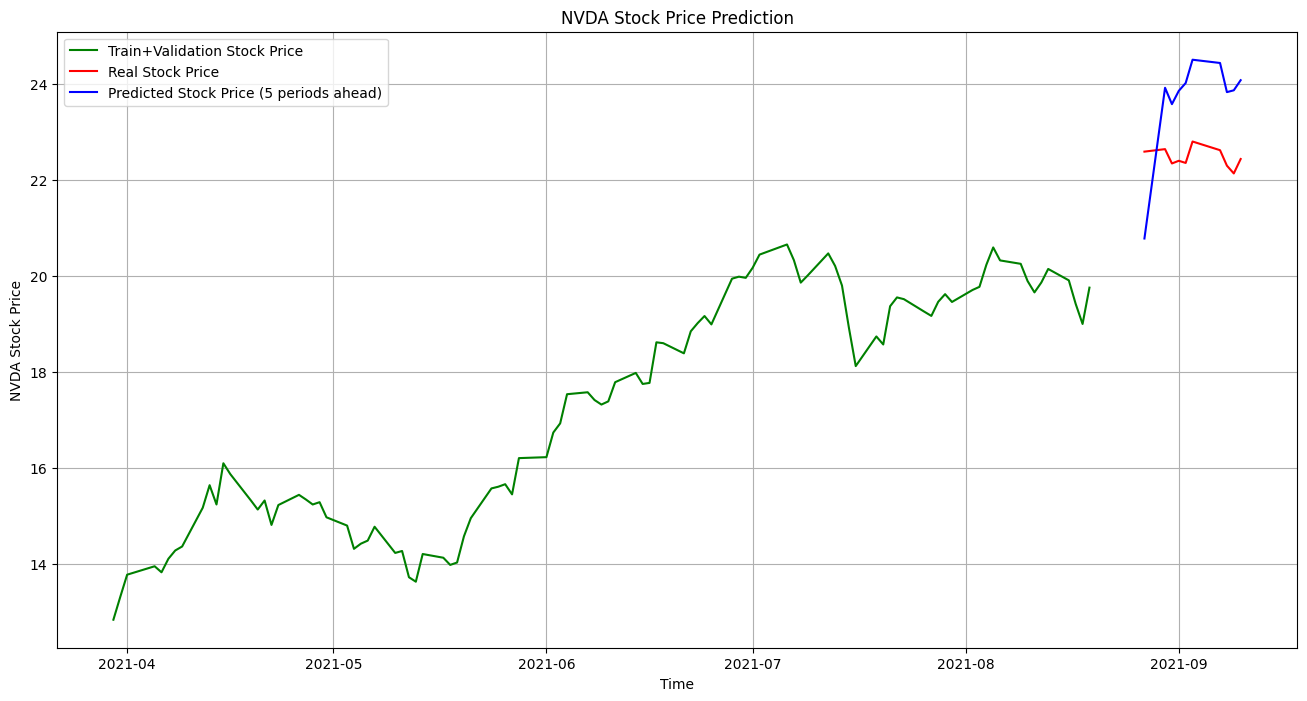

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
test
plt.plot(train_validation.index[-100:], train_validation.tail(100), color='green', label = 'Train+Validation Stock Price')
plt.plot(test.index[5:PERIODS_TO_PREDICT+5], test[5:PERIODS_TO_PREDICT+5], color = 'red', label = 'Real Stock Price')
plt.plot(test.index[5:PERIODS_TO_PREDICT+5], predictions, color = 'blue', label = 'Predicted Stock Price (5 periods ahead)')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## 1.4) [Code Snippet 5] Binary Decision Tree

In [95]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

### 1.4.1) Define dataframes AND perform data cleaning
* define X_train (dataframe), X_test (dataframe), y_train (series), y_test (series)
* replace +-inf. with 0
* fill NaNs with 0 (you can drop it too, but will loose a lot of data in our case
* remove 1-2% outliers (in each dimension, or only in variable to_predict :: we won't use it for a Decision Tree

In [96]:
# Decision Tree doesn't like too large and inf. values
import numpy as np

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_infinite_values(X)

In [97]:
# look carefully for 'count' to be close to total values (or you need to replace NaNs/remove NaNs), and min/max doesn't equal to -+inf.
#  it will give you an idea to dig deeper into some features to understand the 'nature' of a problem
pd.set_option('display.max_rows', None)

new_df[NUMERICAL+DUMMIES].describe().T

c:\Users\paulina.pyzel\sa\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



count          mean           std           min  \
growth_1d                191780.0  1.000859e+00  2.452123e-02  2.300550e-01   
growth_3d                191750.0  1.002521e+00  3.993495e-02  2.425170e-01   
growth_7d                191690.0  1.005780e+00  5.852670e-02  2.326554e-01   
growth_30d               191345.0  1.024514e+00  1.175381e-01  2.461313e-01   
growth_90d               190445.0  1.075941e+00  2.187319e-01  1.890118e-01   
growth_365d              186035.0  1.357578e+00  6.215502e-01  9.783037e-02   
growth_dax_1d            188637.0  1.000281e+00  1.405046e-02  8.776139e-01   
growth_dax_3d            188637.0  1.000911e+00  2.396851e-02  8.374862e-01   
growth_dax_7d            188637.0  1.002258e+00  3.562933e-02  7.318924e-01   
growth_dax_30d           188637.0  1.009702e+00  7.119843e-02  6.263172e-01   
growth_dax_90d           188637.0  1.029157e+00  1.233678e-01  5.580989e-01   
growth_dax_365d          188637.0  1.114489e+00  2.493790e-01  4.232260e-01   
growth_snp500_1d         189509.0  1.000309e+00  1.216216e-02  8.801594e-01   
growth_snp500_3d         189509.0  1.000919e+00  1.954460e-02  8.609410e-01   
growth_snp500_7d         189509.0  1.002170e+00  2.831597e-02  7.744819e-01   
growth_snp500_30d        189509.0  1.009152e+00  5.522370e-02  6.723542e-01   
growth_snp500_90d        189509.0  1.027191e+00  9.097912e-02  6.041948e-01   
growth_snp500_365d       189509.0  1.116963e+00  2.014744e-01  4.459040e-01   
growth_dji_1d            189509.0  1.000275e+00  1.153659e-02  8.707345e-01   
growth_dji_3d            189509.0  1.000830e+00  1.868549e-02  8.571448e-01   
growth_dji_7d            189509.0  1.001968e+00  2.742097e-02  7.728764e-01   
growth_dji_30d           189509.0  1.008314e+00  5.304167e-02  6.388428e-01   
growth_dji_90d           189509.0  1.024499e+00  8.327950e-02  6.713951e-01   
growth_dji_365d          189509.0  1.104315e+00  1.690131e-01  4.751590e-01   
growth_epi_1d            136321.0  1.000305e+00  1.751807e-02  8.695652e-01   
growth_epi_3d            136265.0  1.000911e+00  2.815710e-02  8.322399e-01   
growth_epi_7d            136153.0  1.002283e+00  4.252862e-02  7.601369e-01   
growth_epi_30d           135514.0  1.010786e+00  9.292186e-02  5.466593e-01   
growth_epi_90d           133807.0  1.033449e+00  1.722565e-01  4.557628e-01   
growth_epi_365d          125968.0  1.165338e+00  3.393253e-01  6.161576e-01   
growth_gold_1d           185394.0  1.000459e+00  1.087830e-02  9.064623e-01   
growth_gold_3d           185350.0  1.001360e+00  1.863199e-02  8.731309e-01   
growth_gold_7d           185262.0  1.003191e+00  2.834238e-02  8.529236e-01   
growth_gold_30d          184756.0  1.013403e+00  5.481536e-02  8.025224e-01   
growth_gold_90d          183436.0  1.039637e+00  9.055750e-02  7.509287e-01   
growth_gold_365d         177114.0  1.164098e+00  2.074832e-01  7.205445e-01   
growth_wti_oil_1d        185620.0  9.998039e-01  5.066807e-02 -2.059661e+00   
growth_wti_oil_3d        185576.0  1.000565e+00  6.153265e-02 -1.893810e+00   
growth_wti_oil_7d        185488.0  1.002325e+00  7.686623e-02 -1.499801e+00   
growth_wti_oil_30d       184982.0  1.012000e+00  1.495413e-01 -9.782089e-01   
growth_wti_oil_90d       183662.0  1.037136e+00  2.375203e-01 -1.153069e+00   
growth_wti_oil_365d      177350.0  1.146295e+00  4.858514e-01 -1.988573e+00   
growth_brent_oil_1d      138694.0  1.000264e+00  2.345154e-02  7.559640e-01   
growth_brent_oil_3d      138638.0  1.000719e+00  4.037272e-02  6.720125e-01   
growth_brent_oil_7d      138526.0  1.001683e+00  6.148880e-02  6.011202e-01   
growth_brent_oil_30d     137889.0  1.007768e+00  1.284585e-01  3.937662e-01   
growth_brent_oil_90d     136223.0  1.025071e+00  2.295032e-01  3.004352e-01   
growth_brent_oil_365d    128448.0  1.075521e+00  4.619627e-01  2.641793e-01   
growth_btc_usd_1d         87021.0  1.002362e+00  3.871495e-02  6.283046e-01   
growth_btc_usd_3d         86957.0  1.006649e+00  6.360126e-02  6.273361e-01   

In [98]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]
X_all = new_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')


length: X_train (160387, 302),  X_test (31408, 302)


In [99]:
# Can't have +-inf values . E.g. ln(volume)=-inf when volume==0 => substitute with 0

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_all.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
X_all.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape}')

length: X_train_imputed (160387, 302),  X_test_imputed (31408, 302)


In [100]:
# you may want to remove 1-2% outliers based on percentile ==> not used here in Decision Trees
def remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99):
    """
    Remove outliers from the input array based on percentiles.

    Parameters:
    - X: Input array (NumPy array or array-like)
    - lower_percentile: Lower percentile threshold (float, default=1)
    - upper_percentile: Upper percentile threshold (float, default=99)

    Returns:
    - Array with outliers removed
    """
    lower_bound = np.percentile(X, lower_percentile, axis=0)
    upper_bound = np.percentile(X, upper_percentile, axis=0)
    mask = np.logical_and(np.all(X >= lower_bound, axis=1), np.all(X <= upper_bound, axis=1))
    return X[mask]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99)

In [101]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)

In [102]:
# same shape
print(f'length: X_train_imputed {X_train_imputed.shape},  X_test_imputed {X_test_imputed.shape}')

length: X_train_imputed (160387, 302),  X_test_imputed (31408, 302)


In [103]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]
del X_all[to_predict]

### 1.4.2 Estimation of a Decision Tree model

In [104]:
# INPUTS:
# X_train_imputed : CLEAN dataFrame with only numerical features (train+validation periods)
# X_test_imputed : CLEAN dataFrame with only numerical features (test periods)

# y_train : true values for the train period
# y_test  : true values for the test period

In [105]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [106]:
%%time
# drop 2 columns before fitting the tree, but we need those columns later for joins
clf_20, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=20)

CPU times: total: 33.2 s
Wall time: 34.4 s


In [107]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

CPU times: total: 20.2 s
Wall time: 20.9 s


In [108]:
# TODO 3: TRAIN only on train dataset, experiment with trees with depth 1..20 --> find the best one on VALID dataset
#       for the "best" tree model: find precision on the TEST set

### 1.4.3 Inference for a Decision Tree

In [109]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df

In [110]:
pred20 = predict_decision_tree(clf_20, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 20
Accuracy =0.5419319918492104, precision = 0.5811975315505643


In [111]:
# Predictions of a decision tree of depth "20"
pred20.pred_.value_counts()

pred_
1    17987
0    13421
Name: count, dtype: int64

In [112]:
pred10 = predict_decision_tree(clf_10, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 10
Accuracy =0.5571510443199185, precision = 0.5889278426037361


In [113]:
pred10.tail()

growth_1d  growth_3d  growth_7d  growth_30d  growth_90d  growth_365d  \
5696   1.006181   1.014449   1.015843    1.134810    1.073741     1.100770   
5697   1.000245   1.010212   1.010617    1.116256    1.074174     1.090360   
5698   1.001359   1.007795   1.010753    1.119455    1.089418     1.074656   
5699   0.978045   0.979613   0.988778    1.088749    1.054443     1.049978   
5700   0.995422   0.974890   0.989218    1.085747    1.058436     1.042976   

      growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  ...  \
5696       0.994645       0.995792       1.010073        1.086855  ...   
5697       0.992274       0.986185       0.999587        1.077044  ...   
5698       0.998388       0.985371       1.000762        1.067916  ...   
5699       0.992590       0.983335       0.986710        1.056651  ...   
5700       0.989264       0.980351       0.968684        1.018607  ...   

      month_wom_October_w3  month_wom_October_w4  month_wom_October_w5  \
5696                     0                     0                     0   
5697                     0                     0                     0   
5698                     0                     0                     0   
5699                     0                     0                     0   
5700                     0                     0                     0   

      month_wom_September_w1  month_wom_September_w2  month_wom_September_w3  \
5696                       0                       0                       0   
5697                       0                       0                       0   
5698                       0                       0                       0   
5699                       0                       0                       0   
5700                       0                       0                       0   

      month_wom_September_w4  month_wom_September_w5  \
5696                       0                       0   
5697                       0                       0   
5698                       0                       0   
5699                       0                       0   
5700                       0                       0   

      is_positive_growth_30d_future  pred_  
5696                              0      0  
5697                              0      1  
5698                              0      1  
5699                              0      1  
5700                              0      1  

[5 rows x 301 columns]

In [114]:
X_test_imputed.join(pred10['pred_']).head()

growth_1d  growth_3d  growth_7d  growth_30d  growth_90d  growth_365d  \
8933   1.025575   1.040476   1.062703    1.097153    1.195848     2.009717   
8934   1.000953   1.047879   1.053218    1.100653    1.178952     2.222400   
8935   0.993337   1.019712   1.035340    1.079078    1.165527     1.932807   
8936   0.997984   0.992279   1.027115    1.071070    1.172168     2.262361   
8937   0.990331   0.981750   1.022460    1.066301    1.162993     2.070046   

      growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  ...  \
8933       1.002679       0.992846       0.998859        1.007656  ...   
8934       1.002831       0.992911       0.994684        1.003944  ...   
8935       1.003347       1.008883       0.995519        1.007360  ...   
8936       0.997159       1.003329       0.995914        1.004540  ...   
8937       0.995773       0.996268       0.991940        1.010490  ...   

      month_wom_October_w4  month_wom_October_w5  month_wom_September_w1  \
8933                     0                     0                       0   
8934                     0                     0                       0   
8935                     0                     0                       0   
8936                     0                     0                       0   
8937                     0                     0                       0   

      month_wom_September_w2  month_wom_September_w3  month_wom_September_w4  \
8933                       0                       0                       0   
8934                       0                       0                       0   
8935                       0                       0                       0   
8936                       0                       0                       0   
8937                       0                       0                       0   

      month_wom_September_w5       Date  Ticker  pred_  
8933                       0 2021-08-20    MSFT      0  
8934                       0 2021-08-23    MSFT      0  
8935                       0 2021-08-24    MSFT      1  
8936                       0 2021-08-25    MSFT      1  
8937                       0 2021-08-26    MSFT      1  

[5 rows x 302 columns]

In [115]:
# Predictions of a decision tree of depth "10" : many more "positive" predictions
pred10.pred_.value_counts()

pred_
1    19111
0    12297
Name: count, dtype: int64

In [116]:
# define a new DF with the SAME index (used for joins)
pred20_df = pred20[['pred_']].rename(columns={'pred_': 'pred_tree_clf20'})
pred20_df.head(1)

pred_tree_clf20
8933                0

In [117]:
# define a new DF with the SAME index (used for joins)
pred10_df = pred10[['pred_']].rename(columns={'pred_': 'pred_tree_clf10'})
pred10_df.head(1)

pred_tree_clf10
8933                0

### 1.4.4 Features Importance and Tree Visualisation of top levels (for clf10)

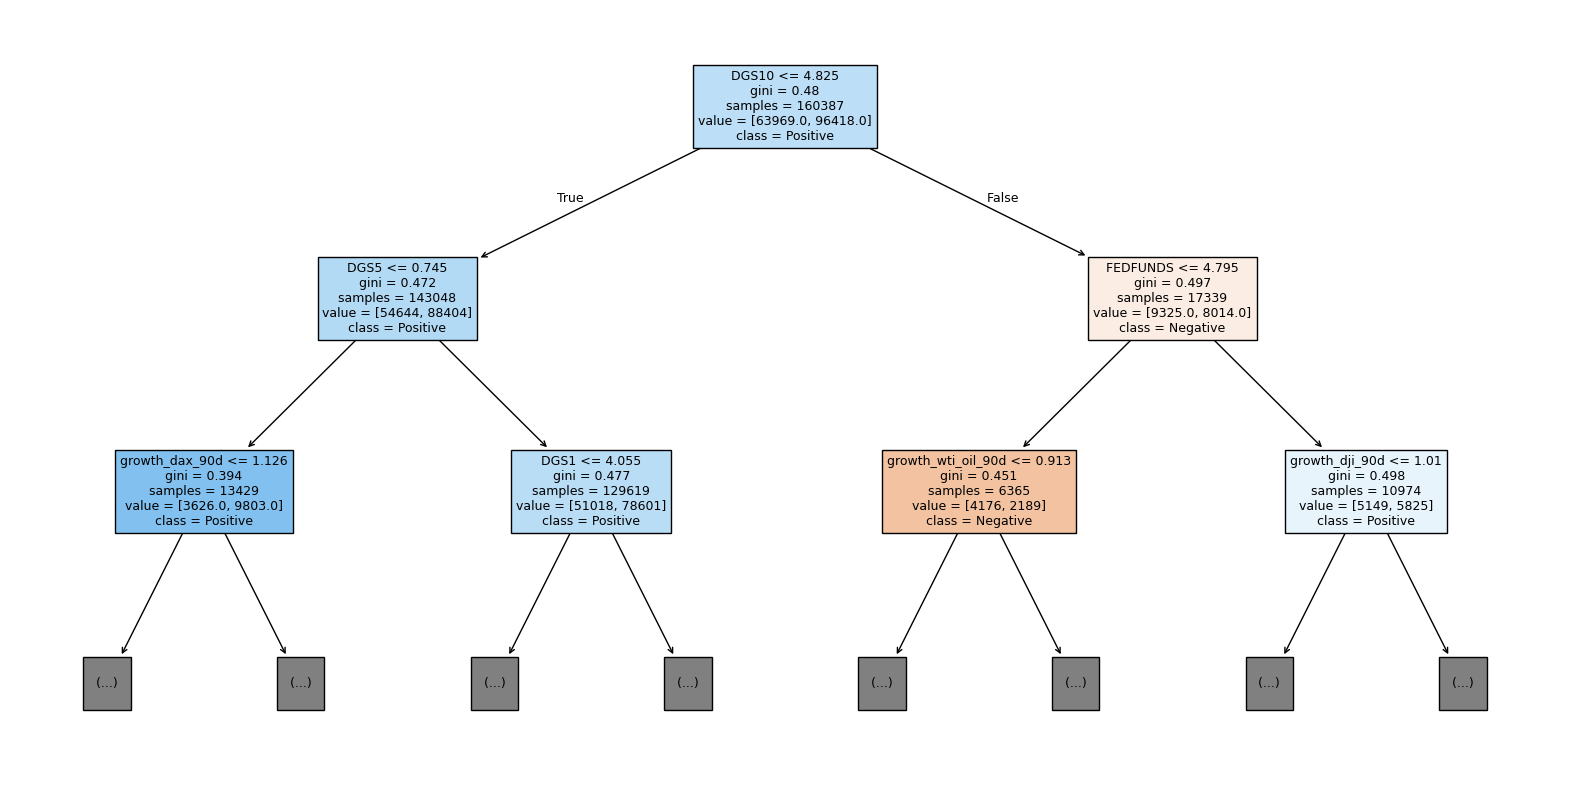

In [118]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(clf_10,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [119]:
# Feautures importance function to predict future returns (based on the classifier)
# get feature importance from 'clf' (classifier) and 'train_columns' (column names)

def get_importances(clf, train_columns):
  # Assuming clf is your trained DecisionTreeClassifier
  feature_importance = clf.feature_importances_

  # Assuming X_train is your training features
  feature_names = train_columns

  # Create a DataFrame to store feature importance
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

  # Sort the DataFrame by importance in descending order
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  # Print or display the feature importance DataFrame
  # print(feature_importance_df)
  return feature_importance_df

In [120]:
get_importances(clf_10, train_columns).head(10)

Feature  Importance
183                DGS10    0.069737
181                 DGS1    0.050300
178         cpi_core_yoy    0.045041
35      growth_gold_365d    0.035765
93                    ad    0.033934
179         cpi_core_mom    0.033414
16     growth_snp500_90d    0.032243
33       growth_gold_30d    0.029912
41   growth_wti_oil_365d    0.029139
95                   obv    0.028833

In [121]:
get_importances(clf_20, train_columns).head(10)

Feature  Importance
93             ad    0.044188
95            obv    0.038937
5     growth_365d    0.036923
90           trix    0.032732
183         DGS10    0.031265
174    volatility    0.025458
178  cpi_core_yoy    0.024088
181          DGS1    0.020690
55           adxr    0.020094
4      growth_90d    0.020047

### 1.4.5 Merge with the original df for predictions (only when predicted on test dataset)

In [122]:
# current predictions from MANUAL
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [123]:
new_df.head()

Open       High        Low    Close_x      Volume  Dividends  \
3490  35.975752  36.358881  34.328300  35.726719  53228400.0        0.0   
3491  34.807221  35.899137  34.404936  34.519875  54119000.0        0.0   
3492  34.060124  35.669264  33.523744  34.883850  64059600.0        0.0   
3493  34.385780  34.903004  33.217238  33.715305  54976600.0        0.0   
3494  33.293845  34.404917  32.891561  34.155884  62013600.0        0.0   

      Stock Splits Ticker  Year    Month  ... pred0_manual_cci  \
3490           0.0   MSFT  2000  January  ...                0   
3491           0.0   MSFT  2000  January  ...                0   
3492           0.0   MSFT  2000  January  ...                0   
3493           0.0   MSFT  2000  January  ...                0   
3494           0.0   MSFT  2000  January  ...                0   

     pred1_manual_prev_g1  pred2_manual_prev_g1_and_snp  pred3_manual_dgs10_5  \
3490                    1                             1                 False   
3491                    1                             0                 False   
3492                    1                             0                 False   
3493                    1                             0                 False   
3494                    1                             1                 False   

      pred4_manual_dgs10_fedfunds  is_correct_pred0  is_correct_pred1  \
3490                        False                 1                 0   
3491                        False                 1                 0   
3492                        False                 1                 0   
3493                        False                 1                 0   
3494                        False                 1                 0   

      is_correct_pred2  is_correct_pred3  is_correct_pred4  
3490                 0                 1                 1  
3491                 1                 1                 1  
3492                 1                 1                 1  
3493                 1                 1                 1  
3494                 0                 1                 1  

[5 rows x 332 columns]

In [124]:
# index in df is not unique
np.sort(new_df.groupby(new_df.index).split.count())

array([ 1,  1,  1, ..., 27, 27, 27], shape=(13371,))

In [125]:
# it's hard to join with pred10_df - as index is totally different
pred10_df.head()

pred_tree_clf10
8933                0
8934                0
8935                1
8936                1
8937                1

In [126]:
# TODO 4: JOIN predictions with the original dataframe (define a new column):
#  so, that there are columns pred_tree_clf10 AND pred_tree_clf20

In [127]:
pred10_df.shape

(31408, 1)

In [128]:
new_df.shape

(191795, 332)

In [129]:
X_test_imputed.shape

(31408, 301)

In [130]:
new_df['pred5_clf_10'] = clf_10.predict(X_all.drop(['Date','Ticker'],axis=1))

In [131]:
PREDICTIONS.append('pred5_clf_10')

In [132]:
new_df[['pred5_clf_10','is_positive_growth_30d_future'] ].head(2)

pred5_clf_10  is_positive_growth_30d_future
3490             0                              0
3491             0                              0

In [133]:
new_df['is_correct_pred5'] = (new_df.pred5_clf_10 == new_df.is_positive_growth_30d_future)

In [134]:
new_df['only_pred5_is_correct'] = (
    (new_df['is_correct_pred5'] == True) &
    (new_df[['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 
         'is_correct_pred3', 'is_correct_pred4']] == 0).all(axis=1)
)

In [135]:
X_test.head(5)

growth_1d  growth_3d  growth_7d  growth_30d  growth_90d  growth_365d  \
8933   1.025575   1.040476   1.062703    1.097153    1.195848     2.009717   
8934   1.000953   1.047879   1.053218    1.100653    1.178952     2.222400   
8935   0.993337   1.019712   1.035340    1.079078    1.165527     1.932807   
8936   0.997984   0.992279   1.027115    1.071070    1.172168     2.262361   
8937   0.990331   0.981750   1.022460    1.066301    1.162993     2.070046   

      growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  ...  \
8933       1.002679       0.992846       0.998859        1.007656  ...   
8934       1.002831       0.992911       0.994684        1.003944  ...   
8935       1.003347       1.008883       0.995519        1.007360  ...   
8936       0.997159       1.003329       0.995914        1.004540  ...   
8937       0.995773       0.996268       0.991940        1.010490  ...   

      month_wom_October_w3  month_wom_October_w4  month_wom_October_w5  \
8933                     0                     0                     0   
8934                     0                     0                     0   
8935                     0                     0                     0   
8936                     0                     0                     0   
8937                     0                     0                     0   

      month_wom_September_w1  month_wom_September_w2  month_wom_September_w3  \
8933                       0                       0                       0   
8934                       0                       0                       0   
8935                       0                       0                       0   
8936                       0                       0                       0   
8937                       0                       0                       0   

      month_wom_September_w4  month_wom_September_w5       Date  Ticker  
8933                       0                       0 2021-08-20    MSFT  
8934                       0                       0 2021-08-23    MSFT  
8935                       0                       0 2021-08-24    MSFT  
8936                       0                       0 2021-08-25    MSFT  
8937                       0                       0 2021-08-26    MSFT  

[5 rows x 301 columns]

In [144]:
df_test = new_df[new_df.split.isin(['test'])]

In [145]:
df_test.shape

(31408, 335)

In [146]:
df_test[df_test['only_pred5_is_correct']==True][['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 
         'is_correct_pred3', 'is_correct_pred4','is_correct_pred5']].head(5)

is_correct_pred0  is_correct_pred1  is_correct_pred2  is_correct_pred3  \
9212                 0                 0                 0                 0   
9213                 0                 0                 0                 0   
9214                 0                 0                 0                 0   
9218                 0                 0                 0                 0   
9219                 0                 0                 0                 0   

      is_correct_pred4  is_correct_pred5  
9212                 0              True  
9213                 0              True  
9214                 0              True  
9218                 0              True  
9219                 0              True

In [147]:
df_test[df_test['only_pred5_is_correct']==True].shape

(3770, 335)

In [148]:
df_test.shape

(31408, 335)